# Loading data

In [1]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True

In [2]:
all_feature = pd.read_csv("all_features.csv")

# Balancing the dataset

In [3]:
print("BKG: ", all_feature["delta_time"][all_feature['Label']==0].shape[0])
print("IBD: ", all_feature["delta_time"][all_feature['Label']==1].shape[0]) 

BKG:  1000081
IBD:  1468385


In [4]:
# Elimina gli elementi desiderati dal dataset
num_IBD = all_feature["delta_time"][all_feature['Label']==1].shape[0]
num_BKG = all_feature["delta_time"][all_feature['Label']==0].shape[0]

del_BKG = 0
del_IBD = 0

if num_IBD > num_BKG:
    del_IBD = num_IBD - num_BKG
    to_del_ibd = all_feature.shape[0] - del_IBD
    order = np.argsort(all_feature["Label"])
    all_feature = all_feature.iloc[order].dropna()
    all_feature = all_feature.iloc[:to_del_ibd]

elif num_IBD < num_BKG:
    del_BKG = num_BKG - num_IBD
    order = np.argsort(all_feature["Label"])
    all_feature = all_feature.iloc[order].dropna()
    all_feature = all_feature.iloc[del_BKG:]

print("BKG:", all_feature["Label"][all_feature['Label']==0].shape[0]) 
print("IBD:",  all_feature["Label"][all_feature['Label']==1].shape[0])

BKG: 1000081
IBD: 1000081


## Creating train and test datasets

In [5]:
from sklearn.model_selection import train_test_split


columns_to_exclude = ['Label', 'Source']


X = all_feature.drop(columns_to_exclude, axis=1)
Y = all_feature['Label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=.1)

## PyTorch Neural Network

In [6]:
type(X_train[1:1+4].values)

numpy.ndarray

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score

# cuda, se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definire il DataSet personalizzato
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_normed = scaler.transform(X_train)
X_test_normed = scaler.transform(X_test)
X_validation_normed = scaler.transform(X_validation)
    
# Creare i set di dati personalizzati
train_dataset = CustomDataset(torch.from_numpy(X_train_normed).float(), torch.from_numpy(y_train.values).long())
test_dataset = CustomDataset(torch.from_numpy(X_test_normed).float(), torch.from_numpy(y_test.values).long())
validation_dataset = CustomDataset(torch.from_numpy(X_validation_normed).float(), torch.from_numpy(y_validation.values).long())

# Creare i DataLoader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=256, shuffle=True)


In [8]:
import os
from tqdm import tqdm

# Definire la rete neurale
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)  # num features from X_train
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 2)  # num classes from y_train

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        # x = torch.sigmoid(self.fc6(x)) #sigmoid
        x = self.fc6(x) 
        return x

# Istanziare la rete e spostarla su cuda  
net = Net().to(device)

# Definire la loss function e l'optimizer
criterion = nn.CrossEntropyLoss()  # Usando la CrossEntropy come funzione di perdita per la classificazione
# criterion = nn.BCEWithLogitsLoss()  # Usando la CrossEntropy come funzione di perdita per la classificazione
optimizer = optim.Adam(net.parameters())

model_path = "def.pth"
# model_path = "torch_net_normed_def.pth"

# Controllare se esiste un file contenente il modello addestrato
if os.path.isfile(model_path):
    # Caricare il modello
    net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    net.eval()
    print("Model loaded")
else:
    # Addestrare la rete
    min_valid_loss = np.inf
    early_stop_steps = 0
    early_stopping_rounds = 10
    for epoch in tqdm(range(2000)):  # 100 epoche
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.unsqueeze(1)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    
        valid_loss = 0.0
        net.eval()     # Optional when not using Model Specific layer
        for data, labels in validation_loader:
            data, labels = data.cuda(), labels.cuda()
            # labels = labels.unsqueeze(1)
            target = net(data)
            loss = criterion(target,labels)
            valid_loss += loss.item()

        print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(validation_loader)}')
        if min_valid_loss > valid_loss:
            early_stop_steps = 0
            min_valid_loss = valid_loss
        else:
            early_stop_steps+=1
            if early_stop_steps >= early_stopping_rounds:
                break


    print('Finished Training')

    # Salvare il modello
    torch.save(net.state_dict(), model_path)

# Calcolare l'accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        # probs_normed = nnf.softmax(outputs, dim=1)
        # _, predicted = probs_normed.topk(1, dim = 1)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test data: %d %%' % (100 * correct / total))


Model loaded
Accuracy of the network on the test data: 99 %


In [9]:
correct, y_test.shape

(399965, (400033,))

In [10]:
torch.max(outputs.data, 1)

torch.return_types.max(
values=tensor([309.8945,   3.9219,  41.2181, 167.5294,   4.0562, 193.8470, 190.7314,
        206.9893,   4.0342,   3.3263,   4.4196, 170.8633,   5.3468,   5.3421,
        350.4037,   5.5273, 138.0428, 130.7700, 451.1251,   5.4692,   5.2300,
        392.2004,   4.0423, 300.4089, 121.1781,   5.1866,   5.5967,   5.4424,
          4.2508,   4.6664, 164.2874,   5.2637, 219.8194, 127.4989,   5.5402,
        294.3438, 288.1706, 211.0255,   5.4973,   5.0910, 214.9054, 110.8283,
          4.9632, 492.5177,   5.9993, 328.8071,  96.3620, 411.4321, 347.7805,
         17.0305,   5.6988, 368.6742,   4.4029,   4.7992, 323.1639, 433.3051,
        347.9173,   5.2544, 155.9712, 296.3250,   4.5727, 190.1845, 211.1883,
         62.5487,   4.9310, 228.2686,   5.1407,  28.7348, 207.8169,   5.2576,
        225.4506, 350.2764,   4.0426, 145.1508,   4.3680,   5.4234,   5.1469,
        402.4542, 338.4625, 475.3933, 103.1033, 128.7821,   4.5651, 130.8985,
        467.5197, 406.1101,  58.2

In [11]:

import torch.nn.functional as nnf
input_tensor = torch.tensor(X_test_normed, dtype=torch.float32).to('cpu')

# y_pred = net(torch.from_numpy(X_test_normed).float().cpu())#,  dtype = torch.float32)

probs = net(input_tensor.to('cuda:0')).to('cpu')
probs_normed = nnf.softmax(probs, dim=1).to('cpu')
probs_normed

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [12]:
probs

tensor([[351.8652, -78.7909],
        [ -3.7858,   3.6440],
        [122.9194, -28.2095],
        ...,
        [ -6.0917,   5.8015],
        [ -4.9467,   4.7081],
        [ -5.7932,   5.4926]], grad_fn=<ToCopyBackward0>)

In [13]:
y_test

1696350    0.0
68348      1.0
2032417    0.0
219796     0.0
1797842    1.0
          ... 
1841439    1.0
113290     1.0
15690      1.0
2459560    1.0
2120626    1.0
Name: Label, Length: 400033, dtype: float64

In [12]:
import sklearn
import torch.nn.functional as nnf

input_tensor = torch.tensor(X_test_normed, dtype=torch.float32).to('cpu')

# y_pred = net(torch.from_numpy(X_test_normed).float().cpu())#,  dtype = torch.float32)

probs = net(input_tensor.to('cuda:0')).to('cpu')
probs_normed = nnf.softmax(probs, dim=1).to('cpu')
p_, y_pred = probs_normed.topk(1, dim = 1)


print(sklearn.metrics.classification_report(y_test, y_pred))
sklearn.metrics.confusion_matrix(y_test, y_pred)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# $\Delta t$ vs $\Delta R$

In [15]:
to_plot_tensor = torch.tensor(X_test[:2000].values, dtype=torch.float32).to('cpu')
probs = net(to_plot_tensor.to('cuda:0')).to('cpu')
probs_normed = nnf.softmax(probs, dim=1).to('cpu')
probs_normed

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]], grad_fn=<SoftmaxBackward0>)

In [16]:
probs

tensor([[53805608.0000, -8688090.0000],
        [ 2934528.7500,  -543297.2500],
        [31958320.0000, -4880594.5000],
        ...,
        [27806966.0000, -4672341.0000],
        [32510640.0000, -5256616.5000],
        [19121184.0000, -3358672.7500]], grad_fn=<ToCopyBackward0>)

In [17]:
y_test[:2000].values

array([0., 1., 0., ..., 0., 0., 0.])

17600


Text(0, 0.5, '$\\Delta$t [ns]')

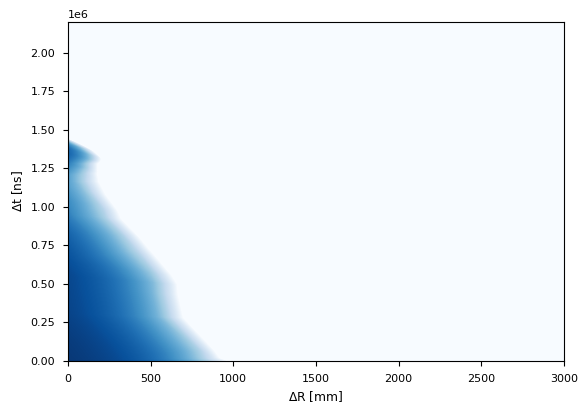

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as nnf

to_plot = pd.DataFrame()
dr_array = np.linspace(0, 3000, 1000)
# dt_array = np.linspace(0, 20*220e3, 1000)
dt_array = np.linspace(0, 10*220e3, 1000)
# dr_array = np.linspace(0, 3000, 1000)
# dt_array = np.linspace(0, 20*220e3, 1000)
dr_mesh, dt_mesh = np.meshgrid(dr_array, dt_array)
elements = len(dr_mesh.flatten())

Radius = np.linspace(0,17600,100).astype(int)
R = Radius[99]
print(R)


to_plot['R_prompt'] = R*np.ones(elements)
to_plot['R_delayed'] = R*np.ones(elements)
to_plot['E_pro'] = 1.*np.ones(elements)
to_plot['delta_radius'] = dr_mesh.flatten()
to_plot['E_del'] = 2.2*np.ones(elements)
to_plot['delta_time'] = dt_mesh.flatten()
to_plot = to_plot[X.columns]
to_plot = scaler.transform(to_plot)

#utilizza net per fare previsione sui dati contenuti in to_plot.
to_plot_tensor = torch.tensor(to_plot, dtype=torch.float32).to('cpu')
probs = net(to_plot_tensor.to('cuda:0')).to('cpu')
probs_normed = probs
probs_normed = nnf.softmax(probs, dim=1).to('cpu')
probs_normed = probs_normed[:, 1].reshape(dr_mesh.shape)
plt.imshow(probs_normed.detach().numpy(), cmap = 'Blues', origin = 'lower', extent = (dr_mesh.min(), dr_mesh.max(), dt_mesh.min(), dt_mesh.max()), aspect = 'auto', vmin = 0.95, vmax = 1)
#plt.scatter(all_feature["delta_radius"][all_feature['Label']==1], all_feature["delta_time"][all_feature['Label']==1])
plt.xlabel(r'$\Delta$R [mm]')
plt.ylabel(r'$\Delta$t [ns]')

   

In [19]:
probs_normed

tensor([[9.9849e-01, 9.9847e-01, 9.9845e-01,  ..., 3.4869e-04, 3.3891e-04,
         3.2913e-04],
        [9.9846e-01, 9.9844e-01, 9.9842e-01,  ..., 3.1710e-04, 3.0798e-04,
         2.9884e-04],
        [9.9843e-01, 9.9841e-01, 9.9839e-01,  ..., 2.8742e-04, 2.7897e-04,
         2.7070e-04],
        ...,
        [2.9323e-38, 2.6231e-38, 2.3466e-38,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.1884e-38, 1.9577e-38, 1.7513e-38,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.6333e-38, 1.4611e-38, 1.3070e-38,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], grad_fn=<ReshapeAliasBackward0>)

/tmp/ipykernel_657205/1524429348.py:25: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contourf(probs_normed.detach().numpy(), cmap = 'Blues', origin = 'lower', extent = (dr_mesh.min(), dr_mesh.max(), R_mesh.min(), R_mesh.max()), aspect = 'auto', vmin = 0., vmax=0.1, levels = 200)


Text(0, 0.5, 'R [mm]')

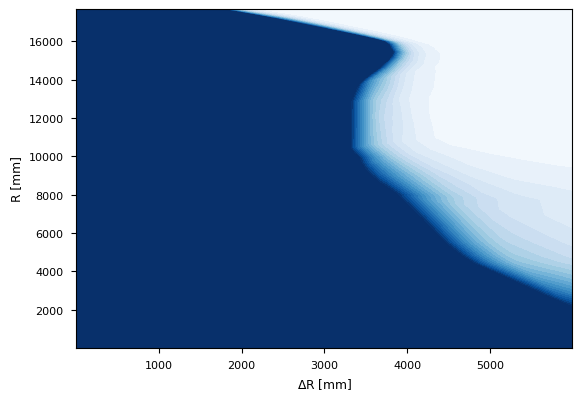

In [20]:
to_plot = pd.DataFrame()

dr_array = np.linspace(0, 6000, 1000)
R_array = np.linspace(0, 17700, 1000)

dr_mesh, R_mesh = np.meshgrid(dr_array, R_array)

elements = len(dr_mesh.flatten())
to_plot['R_prompt'] = R_mesh.flatten()
to_plot['R_delayed'] = to_plot['R_prompt']
to_plot['E_pro'] = 1.*np.ones(elements)
to_plot['delta_radius'] = dr_mesh.flatten()
to_plot['E_del'] = 2.2*np.ones(elements)
to_plot['delta_time'] = 220e3
to_plot = to_plot[X.columns]
to_plot = scaler.transform(to_plot)


#utilizza net per fare previsione sui dati contenuti in to_plot.
to_plot_tensor = torch.tensor(to_plot, dtype=torch.float32).to('cpu')
probs = net(to_plot_tensor.to('cuda:0')).to('cpu')
probs_normed = nnf.softmax(probs, dim=1).to('cpu')
probs_normed = probs_normed[:, 1].reshape(dr_mesh.shape)

plt.contourf(probs_normed.detach().numpy(), cmap = 'Blues', origin = 'lower', extent = (dr_mesh.min(), dr_mesh.max(), R_mesh.min(), R_mesh.max()), aspect = 'auto', vmin = 0., vmax=0.1, levels = 200)

plt.xlabel(r'$\Delta$R [mm]')
plt.ylabel(r'R [mm]')

/tmp/ipykernel_657205/3619632910.py:25: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contour(probs_normed.detach().numpy(), cmap = 'Blues', origin = 'lower', extent = (dr_mesh.min(), dr_mesh.max(), dt_mesh.min(), dt_mesh.max()), aspect = 'auto')


Text(0, 0.5, '$\\Delta$t [mm]')

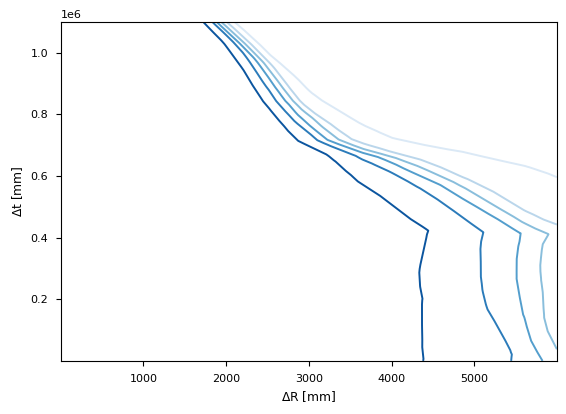

In [21]:
to_plot = pd.DataFrame()

dr_array = np.linspace(0, 6000, 1000)
dt_array = np.linspace(0, 5*220e3, 1000)

dr_mesh, dt_mesh = np.meshgrid(dr_array, dt_array)
R = 0
elements = len(dr_mesh.flatten())
to_plot['R_prompt'] = R*np.ones(elements)
to_plot['R_delayed'] = to_plot['R_prompt']
to_plot['E_pro'] = 1.*np.ones(elements)
to_plot['delta_radius'] = dr_mesh.flatten()
to_plot['E_del'] = 2.2*np.ones(elements)
to_plot['delta_time'] = dt_mesh.flatten()
to_plot = to_plot[X.columns]
to_plot = scaler.transform(to_plot)


#utilizza net per fare previsione sui dati contenuti in to_plot.
to_plot_tensor = torch.tensor(to_plot, dtype=torch.float32).to('cpu')
probs = net(to_plot_tensor.to('cuda:0')).to('cpu')
probs_normed = nnf.softmax(probs, dim=1).to('cpu')
probs_normed = probs_normed[:, 1].reshape(dr_mesh.shape)

plt.contour(probs_normed.detach().numpy(), cmap = 'Blues', origin = 'lower', extent = (dr_mesh.min(), dr_mesh.max(), dt_mesh.min(), dt_mesh.max()), aspect = 'auto')

plt.xlabel(r'$\Delta$R [mm]')
plt.ylabel(r'$\Delta$t [mm]')

In [22]:
# to_plot = pd.DataFrame()

# dt_array = np.linspace(0, 220e3, 1000)
# R_array = np.linspace(0, 17700, 1000)

# dt_mesh, R_mesh = np.meshgrid(dt_array, R_array)

# elements = len(dt_mesh.flatten())
# to_plot['R_prompt'] = R_mesh.flatten()
# to_plot['R_delayed'] = to_plot['R_prompt']
# to_plot['E_pro'] = 1.*np.ones(elements)
# to_plot['delta_radius'] =  3000.*np.ones(elements)
# to_plot['E_del'] = 2.2*np.ones(elements)
# to_plot['delta_time'] = dt_mesh.flatten()
# to_plot = to_plot[X.columns]
# to_plot = scaler.transform(to_plot)


# #utilizza net per fare previsione sui dati contenuti in to_plot.
# to_plot_tensor = torch.tensor(to_plot, dtype=torch.float32).to('cpu')
# probs = net(to_plot_tensor.to('cuda:0')).to('cpu')
# probs_normed = nnf.softmax(probs, dim=1).to('cpu')
# probs_normed = probs_normed[:, 1].reshape(dt_mesh.shape)

# plt.contour(probs_normed.detach().numpy(), cmap = 'Blues', origin = 'lower', extent = (dt_mesh.min(), dt_mesh.max(), R_mesh.min(), R_mesh.max()), aspect = 'auto')

# plt.xlabel(r'$\Delta$t [mm]')
# plt.ylabel(r'R [mm]')

/home/fcufino/.local/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/fcufino/.local/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max

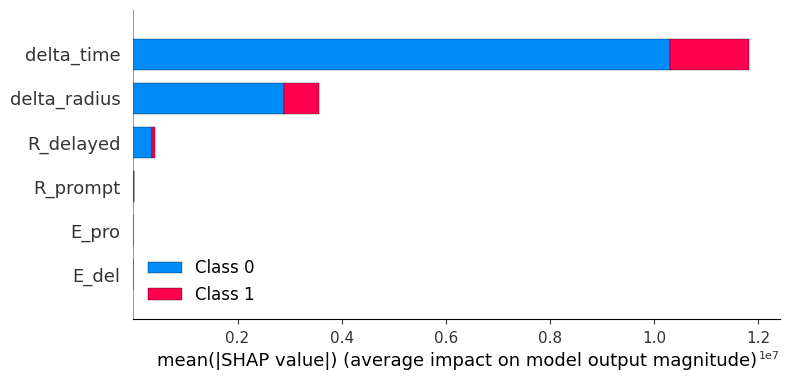

In [23]:
import shap
features_names = X.columns
dataset = torch.autograd.Variable(torch.tensor(X_test[:200].values, dtype=torch.float32)).to("cuda:0")
#Creo un oggetto explainer SHAP
explainer = shap.DeepExplainer(net, dataset)

# Calcolo i valori di Shapley per il set di test
shap_values = explainer.shap_values(dataset)
 
# Plotto il summary plot di SHAP
shap.summary_plot(shap_values, dataset, feature_names=features_names);

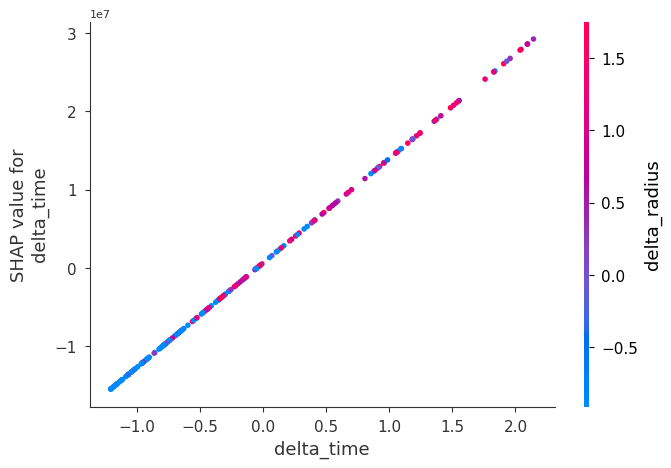

In [24]:
shap.dependence_plot("delta_time", shap_values[0], pd.DataFrame(X_test_normed[:200], columns = X_test.columns), interaction_index="delta_radius")


In [25]:
dataset

tensor([[1.6841e+00, 3.1700e+04, 1.6313e-01, 1.5468e+04, 1.0209e+06, 1.7399e+04],
        [2.2054e+00, 4.3704e+02, 5.1529e+00, 1.7118e+04, 1.5360e+04, 1.7400e+04],
        [1.5688e-01, 9.0991e+03, 5.6524e-01, 1.3883e+04, 6.6711e+05, 1.2463e+04],
        ...,
        [1.6197e+00, 2.4043e+02, 2.1730e+00, 1.5176e+04, 4.2816e+04, 1.5157e+04],
        [2.1137e+00, 4.3979e+02, 2.2753e+00, 6.5846e+03, 2.3110e+05, 6.5322e+03],
        [1.3849e+00, 3.0072e+04, 1.7948e+00, 1.7399e+04, 1.4957e+05, 1.7342e+04]],
       device='cuda:0')

In [26]:
# # Importnce plot
# shap.plots.bar(shap_values[0])

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


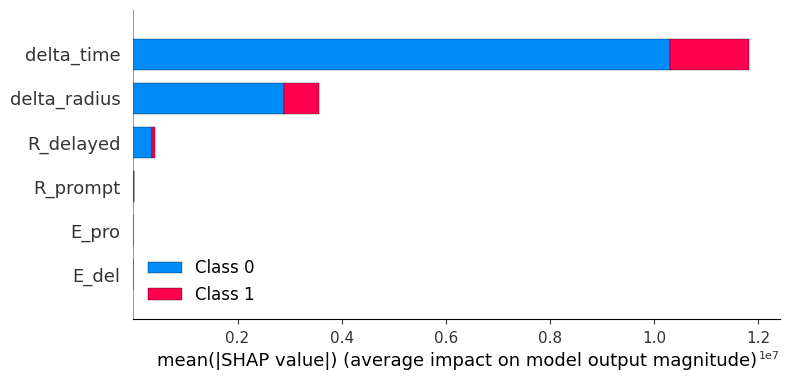

In [27]:
import shap
features_names = X.columns
dataset = torch.tensor(X_test[:200].values, dtype=torch.float32).to('cuda:0')
#Creo un oggetto explainer SHAP
explainer = shap.DeepExplainer(net, dataset)

# Calcolo i valori di Shapley per il set di test
shap_values = explainer.shap_values(dataset)
 
# Plotto il summary plot di SHAP
shap.summary_plot(shap_values, dataset, feature_names=features_names);